- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [4]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True
    
if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python
    #!git pull


Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:4 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [881 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2420 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1979 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1331 kB]33m
Get:9 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [27.5 kB]33m
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [30.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [1411 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64

- enable module autoreload and fix an import bug

In [3]:
%load_ext autoreload
%autoreload 2


import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [4]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from DataGenerator import DataGenerator

- slice each image to small samples of size 188*188
- imgs -> rgb image
- mask -> mask
- edge -> edge_mask

In [5]:
_batch_size = 8

database1 = "data_platlets"

train_img_tile_files = sorted(glob.glob(f'{database1}/train/tiles/*.jpg'))
train_mask_tile_label_files = sorted(glob.glob(f'{database1}/train/mask/tiles/*.jpg'))


database2 = "data_platlets"

test_img_tile_files = sorted(glob.glob(f'{database2}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database2}/test/mask/tiles/*.jpg'))


train_gen = DataGenerator(train_img_tile_files, train_mask_tile_label_files, None, _batch_size, skip_empty = True, skip_empty_mask = True, noise_prob=0)

test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, None, _batch_size, skip_empty = True, skip_empty_mask = True, augment=False)


skipping empty images with keep probability of 0.05
before skip we have 32462 images


100%|██████████| 32462/32462 [00:00<00:00, 34230.14it/s]


after skip we have 3148 images
skipping empty images with keep probability of 0.05
before skip we have 18228 images


100%|██████████| 18228/18228 [00:00<00:00, 33561.28it/s]

after skip we have 1481 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


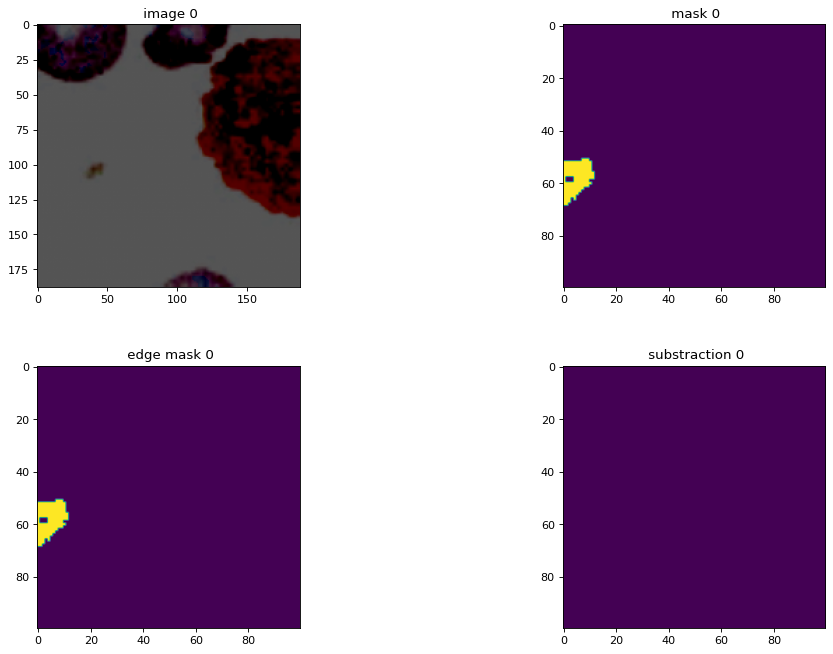

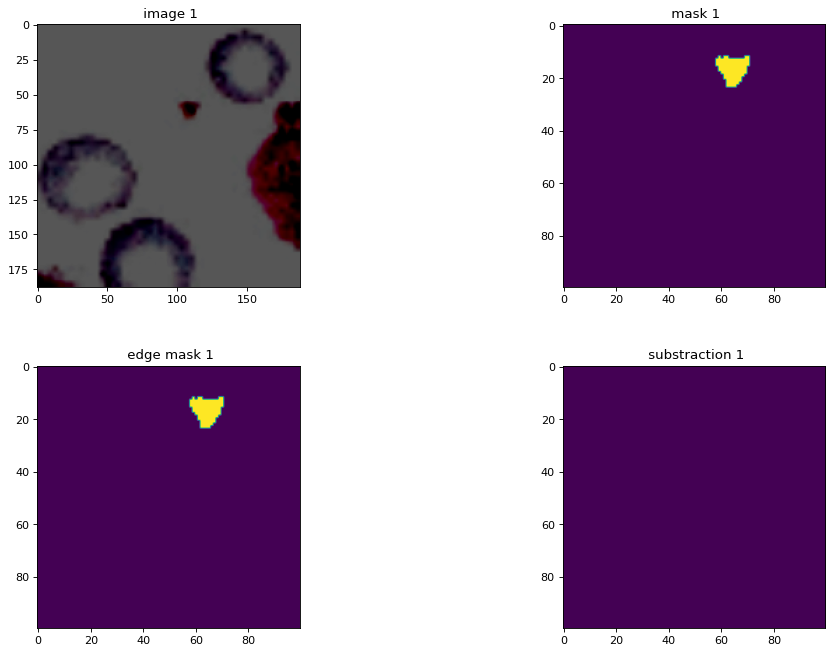

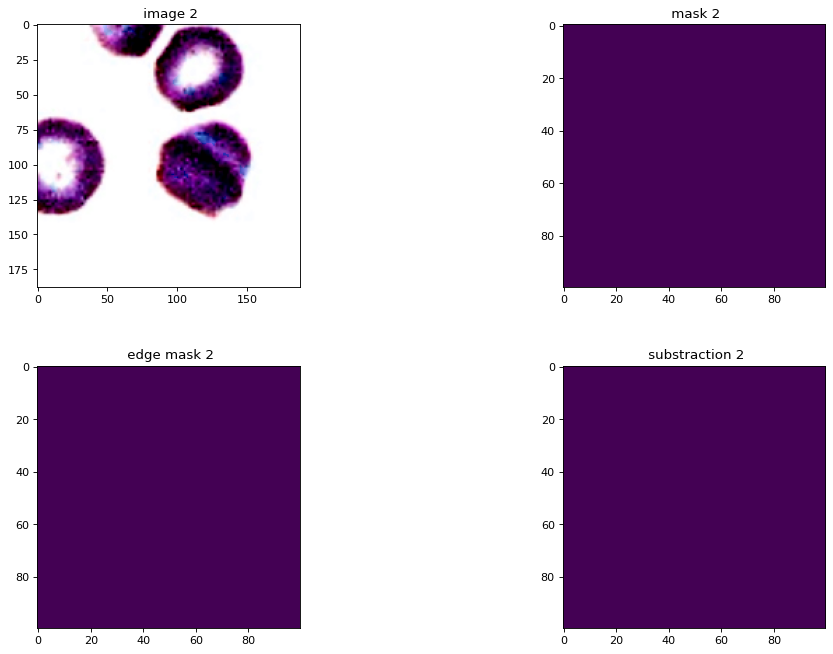

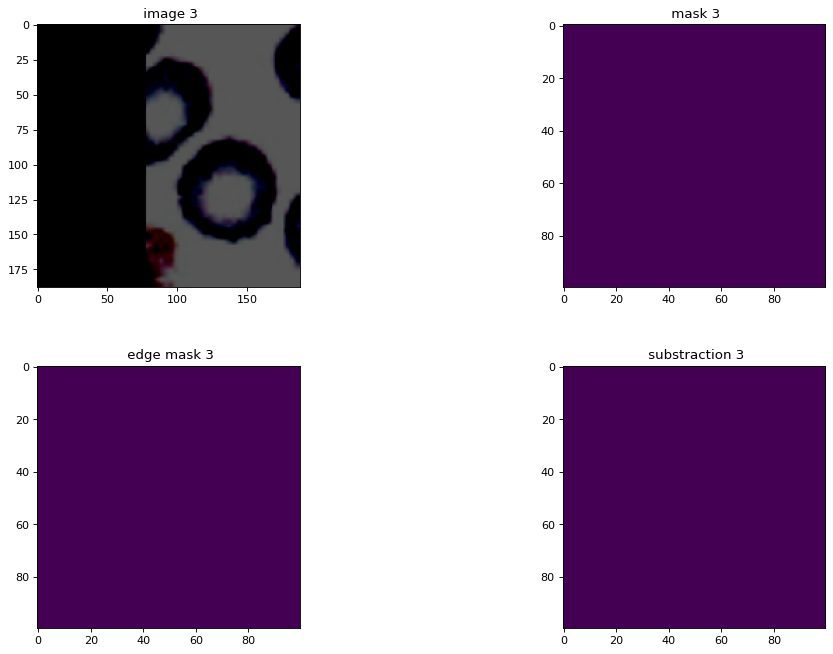

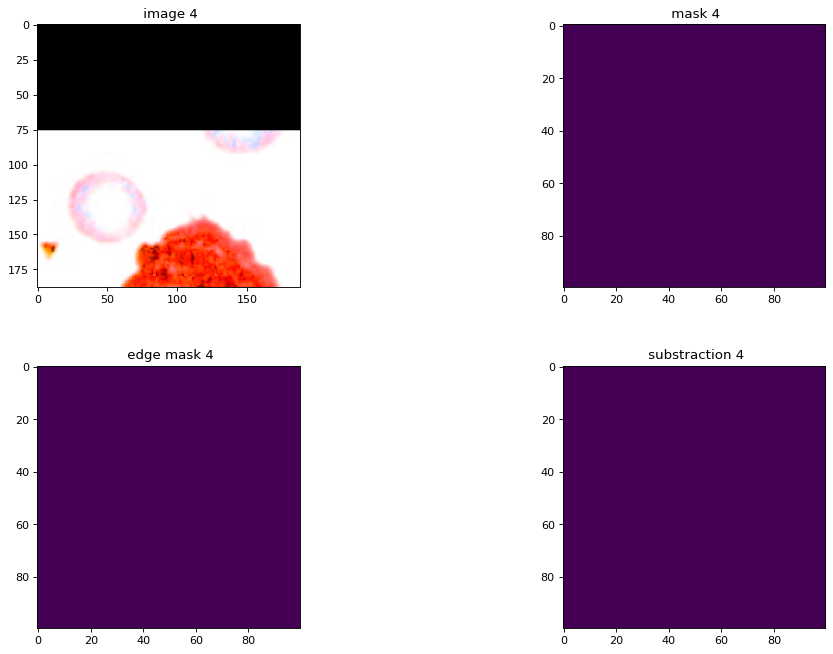

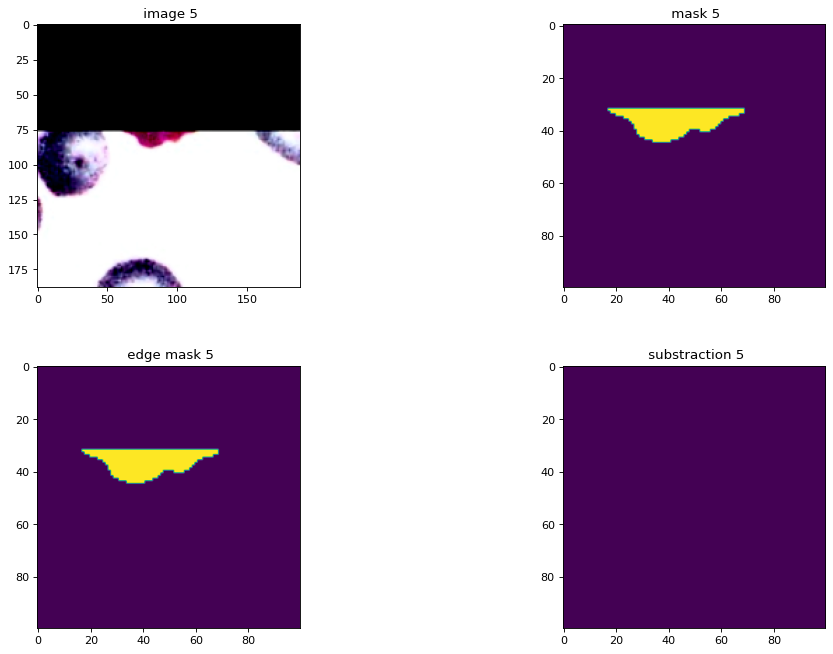

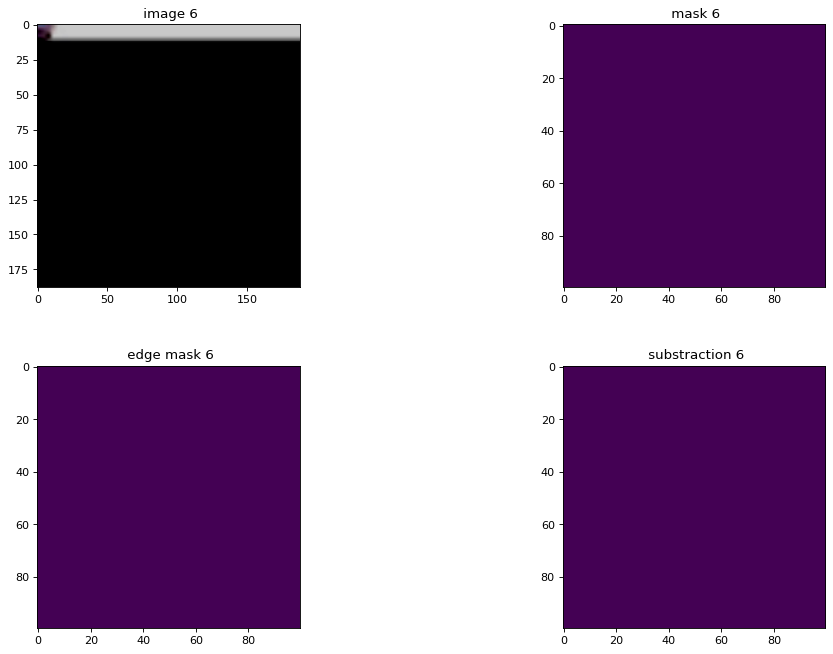

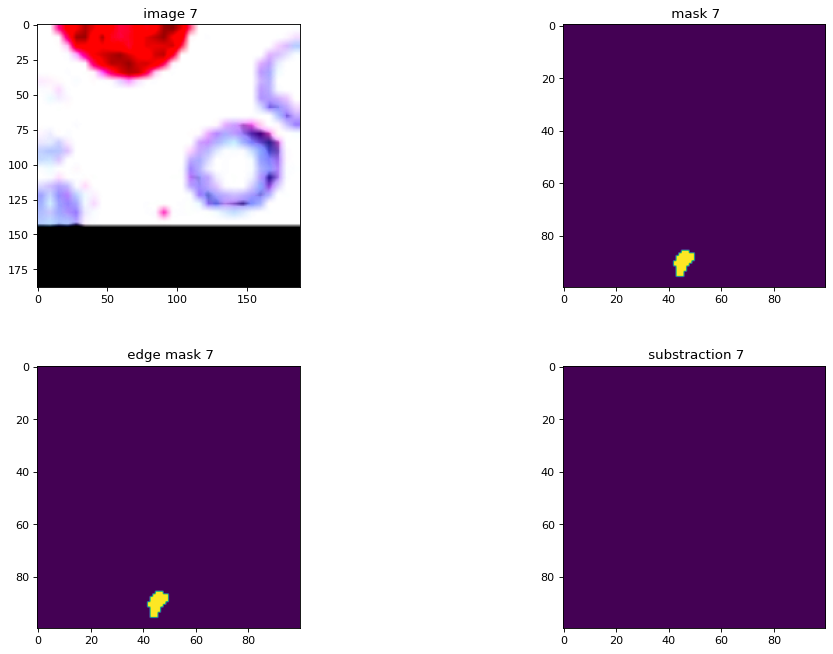

In [5]:
image, mask = train_gen.__getitem__(17)

data.plot_ime(image, mask, mask)

- model parameters

In [6]:
_epochs = 50
_workers = 8
loss_func = "BinaryCrossentropy"
_model_name = f'PLT_{loss_func}_{_epochs}'
images_per_epoch = 1000
train_steps = images_per_epoch//_batch_size
#validation_steps = len(test_img_files)//_batch_size

Train = True

- load model and compile it

In [1]:
_model_name = "PLT_BinaryCrossentropy_50"

In [2]:
objects = {
    "tversky_loss":model.tversky_loss,
    "mean_iou": model.mean_iou,
    "dsc":model.dsc,
    "tversky":model.tversky,
    "tversky_b":model.tversky_b,
    "acc": tf.keras.metrics.Accuracy,
    "tversky_loss_b": model.tversky_loss_b
}


unet = tf.keras.models.load_model(f'./models/{_model_name}', custom_objects=objects)

unet.compile(optimizer="adam",
             loss="BinaryCrossentropy",
             metrics=[model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'])

#unet.summary()

NameError: name 'model' is not defined

- Evaluate

In [ ]:
unet.evaluate(test_gen)

- create the model and compile it

In [14]:
unet = model.get_do_unet_WBC(compile = False)

unet.compile(optimizer="adam",
             loss="BinaryCrossentropy",
             metrics=[model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'])

#unet.summary()

- load weights

In [38]:
unet.load_weights(f"models/....h5")

- Train the model

In [11]:
_model_name = _model_name + "_plus_epochs"

In [15]:
if Train:
    try:
        os.remove(f"models/{_model_name}_best.h5")
        os.remove(f"models/{_model_name}_all.h5")
    except:
        pass
    
    history = unet.fit(train_gen, 
            epochs=_epochs, 
            validation_data=train_gen, 
            steps_per_epoch=train_steps,
            max_queue_size=10*_workers,
            use_multiprocessing=True,
            workers=_workers,
            verbose=1,
            callbacks=model.get_callbacks(_model_name))
    # saving the model in tensorflow format
    unet.save(f'./models/{_model_name}',save_format='tf')

Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.1725 - mean_iou: 0.0432 - dsc: 0.0600 - tversky: 0.0847 - tversky_b: 0.2295 - acc: 0.9749
Epoch 00001: val_loss improved from inf to 0.17177, saving model to models/PLT_BinaryCrossentropy_20_best.h5
125/125 [==============================] - 38s 278ms/step - loss: 0.1725 - mean_iou: 0.0432 - dsc: 0.0600 - tversky: 0.0847 - tversky_b: 0.2295 - acc: 0.9749 - val_loss: 0.1718 - val_mean_iou: 0.0000e+00 - val_dsc: 0.0236 - val_tversky: 0.0345 - val_tversky_b: 0.0436 - val_acc: 0.9880
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.0739 - mean_iou: 0.0158 - dsc: 0.0618 - tversky: 0.0791 - tversky_b: 0.1022 - acc: 0.9879
Epoch 00002: val_loss improved from 0.17177 to 0.06546, saving model to models/PLT_BinaryCrossentropy_20_best.h5
125/125 [==============================] - 35s 273ms/step - loss: 0.0739 - mean_iou: 0.0158 - dsc: 0.0618 - tversky: 0.0791 - tversky_b: 0.1022 - acc: 0.9879 - val_loss

- save the training log 

In [16]:
#save the training log into a file
import json
with open(f"models/{_model_name}_log.json", "w+") as fp:
    json.dump(history.history,fp)

# Opening JSON file
with open(f"models/{_model_name}_log.json") as fp:
    # returns JSON object as
    # a dictionary
    loaded_hist = json.load(fp)

In [ ]:
#rand_index = np.random.randint(0, len(test_img_chips), 1)[0]
#img = test_img_chips[rand_index]
#mask = np.squeeze(test_mask_chips[rand_index])
#edge = np.squeeze(test_edge_chips[rand_index])

test_img_chips, test_mask_chips = test_gen.__getitem__(35)


prediction = unet.predict(test_img_chips)


data.plot_ime(test_img_chips, prediction[0])



- predict full image

In [ ]:
images, masks = model.predictFullImage(unet,
                        data.load_data_na(sorted(glob.glob(f'data_platlets/test/*.jpg'))[:20], RGB=True, clahe=True),
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False,
                        edge = False)

ValueError: cannot reshape array of size 10000 into shape (21,28,100,100,1)

In [ ]:
data.plot_ime(images,
              masks,
              masks,
              figSize=(25,15))

## model training data plot

In [ ]:
hist = history.history

lines = 4
columns = 3

fig = plt.figure(figsize=(20, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask accuracy")
ax.plot(hist['mask_acc'], label="Training")
ax.plot(hist['val_mask_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge mask accuracy")
ax.plot(hist['edge_acc'], label="Training")
ax.plot(hist['val_edge_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 2
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask loss")
ax.plot(hist['mask_loss'], label="Training")
ax.plot(hist['val_mask_loss'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge loss")
ax.plot(hist['edge_loss'], label="Training")
ax.plot(hist['val_edge_loss'], label="Validation")
ax.legend()

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("global loss")
ax.plot(hist['loss'], label="Training")
ax.plot(hist['val_loss'], label="Validation")
ax.legend()


fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask metrics")
ax.plot(hist['mask_dsc'], label="dsc")
ax.plot(hist['mask_mean_iou'], label="mean iou")
ax.plot(hist['mask_tversky'], label="tversky")
ax.plot(hist['mask_acc'], label="accuracy")

ax.set_title("mask metrics")
ax.plot(hist['val_mask_dsc'], label="val_dsc")
ax.plot(hist['val_mask_mean_iou'], label="val_mean iou")
ax.plot(hist['val_mask_tversky'], label="val_tversky")
ax.plot(hist['val_mask_acc'], label="val_accuracy")

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge metrics")
ax.plot(hist['edge_dsc'], label="dsc")
ax.plot(hist['edge_mean_iou'], label="mean iou")
ax.plot(hist['edge_tversky'], label="tversky")
ax.plot(hist['edge_acc'], label="accuracy")

ax.set_title("edge metrics")
ax.plot(hist['val_edge_dsc'], label="val_dsc")
ax.plot(hist['val_edge_mean_iou'], label="val_mean iou")
ax.plot(hist['val_edge_tversky'], label="val_tversky")
ax.plot(hist['val_edge_acc'], label="val_accuracy")
ax.legend()

## For Debugging
- show in between layers output

In [17]:
ind = np.random.randint(0, 32, 1)[0]

_pool1 = pool1[:-1,:-1,ind]
_pool2 = pool2[:-1,:-1,ind]
_pool3 = pool3[:-1,:-1,ind]
_down4 = down4[:-1,:-1,ind]
_up1 = up1[:-1,:-1,ind]
_up2 = up2[:-1,:-1,ind]
_up3 = up3[:-1,:-1,ind]

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_mask")
ax.imshow(out_mask)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_edge")
ax.imshow(out_edge)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool1")
ax.imshow(_pool1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool2")
ax.imshow(_pool2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool3")
ax.imshow(_pool3)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("down4")
ax.imshow(_down4)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up1")
ax.imshow(_up1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up2")
ax.imshow(_up2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up3")
ax.imshow(_up3)

NameError: name 'pool1' is not defined

- function to plot and array of images of shape (width, height, n_images)

In [ ]:
def picshow(img, title):
    num = img.shape[2]
    imgs_per_line = 4
    ax = num//imgs_per_line + 1
    ay = imgs_per_line
    fig =plt.figure(figsize=(30, num//imgs_per_line * 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(1,num + 1):
        sub = fig.add_subplot(ax,ay,i)
        sub.set_title(f"{title} {i}")
        sub.imshow(img[:-1,:-1,i - 1])
    plt.show()
    



In [ ]:
picshow(pool1, 'pool1 ')
picshow(pool2, 'pool2 ')
picshow(pool3, 'pool3 ')
picshow(down4, 'down4 ')
picshow(up1, 'up1 ')
picshow(up2, 'up2 ')
picshow(up3, 'up3 ')